In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pip install plotly == 6.1.1
import plotly.graph_objects as go
from plotly.subplots import make_subplots 

zsh:1: = not found
Note: you may need to restart the kernel to use updated packages.


- Import main libraries: pandas, numpy, matplotlib, plotly
- Install Plotly 6.1.1 via pip
- Prepare plotting and figure utilities for later cells

In [8]:
df_raw = pd.read_csv('tech_stocks.csv') 

print(df_raw.columns)
print(df_raw.info()) 


Index(['Price', 'Close', 'Close.1', 'Close.2', 'Close.3', 'Close.4', 'Close.5',
       'Close.6', 'High', 'High.1', 'High.2', 'High.3', 'High.4', 'High.5',
       'High.6', 'Low', 'Low.1', 'Low.2', 'Low.3', 'Low.4', 'Low.5', 'Low.6',
       'Open', 'Open.1', 'Open.2', 'Open.3', 'Open.4', 'Open.5', 'Open.6',
       'Volume', 'Volume.1', 'Volume.2', 'Volume.3', 'Volume.4', 'Volume.5',
       'Volume.6'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 36 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     576 non-null    object
 1   Close     575 non-null    object
 2   Close.1   575 non-null    object
 3   Close.2   575 non-null    object
 4   Close.3   575 non-null    object
 5   Close.4   575 non-null    object
 6   Close.5   575 non-null    object
 7   Close.6   575 non-null    object
 8   High      575 non-null    object
 9   High.1    575 non-null    object
 10  High.2

- Load raw CSV `tech_stocks.csv` into `df_raw`
- Inspect dataset structure: print columns and info

In [9]:
df_raw.head()

,Price,Close,Close.1,Close.2,Close.3,Close.4,Close.5,Close.6,High,High.1,...,Open.4,Open.5,Open.6,Volume,Volume.1,Volume.2,Volume.3,Volume.4,Volume.5,Volume.6
0,Ticker,AAPL,AMZN,GOOG,META,MSFT,NVDA,TSLA,AAPL,AMZN,...,MSFT,NVDA,TSLA,AAPL,AMZN,GOOG,META,MSFT,NVDA,TSLA
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-03,123.63253784179688,85.81999969482422,89.27714538574219,124.15485382080078,235.24005126953125,14.303279876708984,108.0999984741211,129.39552641230082,86.95999908447266,...,238.67664937100366,14.838841304566728,118.47000122070312,112117500,76706000,20738500,35528500,25740000,401277000,231402800
3,2023-01-04,124.90769958496094,85.13999938964844,88.29180908203125,126.77252197265625,224.94989013671875,14.736924171447754,113.63999938964844,127.18126787275598,86.9800033569336,...,228.07227767052504,14.555073972815984,109.11000061035156,89113600,68885100,27046500,32397100,50623400,431324000,180389000
4,2023-01-05,123.58309936523438,83.12000274658203,86.36095428466797,126.34454345703125,218.2828826904297,14.253320693969727,110.33999633789062,126.30149268134268,85.41999816894531,...,223.0843004172486,14.479135485903637,110.51000213623047,80962700,67930800,23136100,25447100,39585600,389168000,157986300


- Display the first rows of `df_raw` to check parsing and values
- Quick visual check of header/data alignment

In [10]:
# Row 0: tickers; row 1: 'Date'/NaN; rows 2+ are data
tickers_row = df_raw.iloc[0]
labels_row = df_raw.iloc[1]

# Data from row 2 onward
df = df_raw.iloc[2:].reset_index(drop=True)

# Rename 'Price' column to Date, and convert to datetime
df = df.rename(columns={'Price': 'Date'})
df['Date'] = pd.to_datetime(df['Date'])

- Parse header rows to extract tickers and labels
- Create `df` from data rows and convert `Price` → `Date`
- Ensure `Date` column is datetime for later indexing and resampling

In [11]:
base_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# Suffix -> ticker name from row 0
suffix_to_ticker = {}

for col in df_raw.columns:
    if col == 'Price':
        continue
    # find suffix part like '', '.1', '.2'
    suffix = col.replace('Close', '').replace('High', '').replace('Low', '').replace('Open', '').replace('Volume', '')
    suffix_to_ticker[suffix] = tickers_row[col]

suffix_to_ticker  # check mapping

{'': 'AAPL',
 '.1': 'AMZN',
 '.2': 'GOOG',
 '.3': 'META',
 '.4': 'MSFT',
 '.5': 'NVDA',
 '.6': 'TSLA'}

- Build suffix → ticker mapping from raw column names
- Prepare `base_cols` mapping for Open/High/Low/Close/Volume per ticker

In [12]:
long_frames = []

for suf, ticker in suffix_to_ticker.items():
    # Build the actual column names for this ticker
    cols = {}
    for base in base_cols:
        colname = base + suf if suf != '' else base
        cols[base] = df[colname].astype(float)

    tmp = pd.DataFrame({
        'Date': df['Date'],
        'Ticker': ticker,
        'Open': cols['Open'],
        'High': cols['High'],
        'Low': cols['Low'],
        'Close': cols['Close'],
        'Volume': cols['Volume'],
    })
    long_frames.append(tmp)

df_long = pd.concat(long_frames, ignore_index=True)


- Stack per-ticker columns into long-format frames
- Build `df_long` with columns: Date, Ticker→Company, Open/High/Low/Close/Volume
- Prepare unified per-row OHLCV data for indicator computations

In [19]:
ticker_to_company = {
    'AAPL': 'Apple',
    'AMZN': 'Amazon',
    'GOOG': 'Alphabet',
    'META': 'Meta',
    'MSFT': 'Microsoft',
    'NVDA': 'NVIDIA',
    'TSLA': 'Tesla',
}

df_long['Company'] = df_long['Ticker'].map(ticker_to_company)
df_long = df_long.drop(columns=['Ticker'])
df_long.head()

,Date,Open,High,Low,Close,Volume,Company
0,2023-01-03,128.782657,129.395526,122.742880,123.632538,112117500.0,Apple
1,2023-01-04,125.431607,127.181268,123.642412,124.907700,89113600.0,Apple
2,2023-01-05,125.668849,126.301493,123.326093,123.583099,80962700.0,Apple
3,2023-01-06,124.561732,128.792531,123.454601,128.130234,87754700.0,Apple
4,2023-01-09,128.970489,131.876702,128.397153,128.654160,70790800.0,Apple


- Map ticker symbols to company names using `ticker_to_company`
- Add `Company` column and drop raw `Ticker` column
- Show head of the cleaned long-format DataFrame

In [22]:
df_tsla = (
    df_long[df_long['Company'] == 'Tesla']
    .sort_values('Date')
    .set_index('Date')
)

ohlcv_tsla = df_tsla[['Open', 'High', 'Low', 'Close', 'Volume']].rename(columns=str.lower)

- Filter `df_long` for Tesla (`Company == 'Tesla'`) and set Date index
- Create `ohlcv_tsla` with lowercase column names for indicator functions

In [24]:
def true_range(high: pd.Series,
               low: pd.Series,
               close: pd.Series) -> pd.Series:
    """
    Classic True Range as used in ATR and Keltner Channels.

    TR_t = max(
        high_t - low_t,
        |high_t - close_{t-1}|,
        |low_t  - close_{t-1}|
    )
    """
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr


def rolling_linreg(series: pd.Series,
                   window: int) -> pd.Series:
    """
    Rolling linear regression, aligned with TradingView's ta.linreg(..., length, 0).

    For each rolling window of length N:
      x = 0, 1, ..., N-1
      Fit y = a + b x via OLS, then return y_hat at x = N-1.

    This matches the visual behavior of Pine's linreg with offset=0:
    the output is the last point on the fitted line.
    """
    x = np.arange(window, dtype=float)
    x_mean = x.mean()
    denom = ((x - x_mean) ** 2).sum()

    def _lr(y_window: np.ndarray) -> float:
        y = np.asarray(y_window, dtype=float)
        y_mean = y.mean()
        cov = ((x - x_mean) * (y - y_mean)).sum()
        slope = cov / denom if denom != 0 else 0.0
        intercept = y_mean - slope * x_mean
        # value at last x (window - 1)
        return float(intercept + slope * x[-1])

    return series.rolling(window).apply(_lr, raw=True)


def squeeze_momentum_indicator(
    df: pd.DataFrame,
    length_bb: int = 20,
    mult_bb: float = 2.0,
    length_kc: int = 20,
    mult_kc: float = 1.5,
    use_true_range: bool = True,
) -> pd.DataFrame:
    """
    Squeeze Momentum Indicator (LazyBear variant) in pandas.

    Parameters
    ----------
    df : DataFrame
        Price data with columns: 'high', 'low', 'close'.
    length_bb : int
        Lookback for Bollinger Bands (default: 20).
    mult_bb : float
        Standard deviation multiplier for Bollinger Bands (default: 2.0).
    length_kc : int
        Lookback for Keltner Channels (default: 20).
    mult_kc : float
        Range multiplier for Keltner Channels (default: 1.5).
    use_true_range : bool
        If True, use True Range in KC; else use (high - low).

    Returns
    -------
    DataFrame
        Columns:
        - 'sqz_on'   : bool, BB inside KC (squeeze on)
        - 'sqz_off'  : bool, BB outside KC (squeeze fired)
        - 'no_sqz'   : bool, neither on nor off
        - 'val'      : float, momentum histogram value
        - 'bcolor'   : str label for histogram color
        - 'scolor'   : str label for squeeze state color
    """
    high = df['high']
    low = df['low']
    close = df['close']

    # -------------------
    # Bollinger Bands
    # -------------------
    source = close
    bb_mid = source.rolling(length_bb).mean()
    bb_std = source.rolling(length_bb).std(ddof=0)
    upper_bb = bb_mid + mult_bb * bb_std
    lower_bb = bb_mid - mult_bb * bb_std

    # -------------------
    # Keltner Channels
    # -------------------
    kc_mid = source.rolling(length_kc).mean()
    if use_true_range:
        rng = true_range(high, low, close)
    else:
        rng = high - low
    kc_range = rng.rolling(length_kc).mean()
    upper_kc = kc_mid + mult_kc * kc_range
    lower_kc = kc_mid - mult_kc * kc_range

    # -------------------
    # Squeeze state flags
    # -------------------
    sqz_on = (lower_bb > lower_kc) & (upper_bb < upper_kc)
    sqz_off = (lower_bb < lower_kc) & (upper_bb > upper_kc)
    no_sqz = (~sqz_on) & (~sqz_off)

    # -------------------
    # Momentum core: linreg of deviation from local "mean"
    # -------------------
    highest_high = high.rolling(length_kc).max()
    lowest_low = low.rolling(length_kc).min()
    # mid of range
    range_mid = (highest_high + lowest_low) / 2.0
    # simple average with SMA(close)
    sma_close_kc = close.rolling(length_kc).mean()
    local_mean = (range_mid + sma_close_kc) / 2.0

    # Series that Pine passes into linreg(...)
    base_series = source - local_mean
    val = rolling_linreg(base_series, length_kc)

    # -------------------
    # Color logic (labels)
    # -------------------
    val_prev = val.shift(1)

    def classify_hist_color(v: float, vp: float) -> str | None:
        """
        Map current and previous val to LazyBear-style color labels.
        """
        if np.isnan(v) or np.isnan(vp):
            return None
        if v > 0:
            return 'lime' if v > vp else 'green'
        if v < 0:
            return 'red' if v < vp else 'maroon'
        return None

    bcolor = [classify_hist_color(v, vp) for v, vp in zip(val.values, val_prev.values)]

    # Squeeze state color for the zero line
    scolor = np.where(
        no_sqz,
        'blue',              # normal
        np.where(
            sqz_on,
            'black',         # in squeeze
            'gray',          # squeeze fired
        ),
    )

    out = pd.DataFrame(index=df.index)
    out['sqz_on'] = sqz_on
    out['sqz_off'] = sqz_off
    out['no_sqz'] = no_sqz
    out['val'] = val
    out['bcolor'] = bcolor
    out['scolor'] = scolor

    return out


- Define helper utilities and indicators:
  - `true_range`: compute classic True Range for ATR/KC
  - `rolling_linreg`: rolling linear regression used by squeeze momentum
  - `squeeze_momentum_indicator`: compute BB vs KC squeeze flags and momentum histogram
- Returns DataFrame with `sqz_on/sqz_off/no_sqz`, `val`, and color labels

- Usage notes for `squeeze_momentum_indicator`
- Key outputs: `val` (histogram), `sqz_on/sqz_off/no_sqz` (squeeze state)
- Typical uses: detect squeezes, derive signal when squeeze fires, plot histogram with color labels

In [25]:
def wavetrend_lazybear(
    df: pd.DataFrame,
    n1: int = 10,   # Channel Length
    n2: int = 21,   # Average Length
    ob_level1: float = 60,
    ob_level2: float = 53,
    os_level1: float = -60,
    os_level2: float = -53,
) -> pd.DataFrame:
    """
    WaveTrend [LazyBear] oscillator (WT_LB) in pandas.

    Parameters
    ----------
    df : DataFrame
        Must contain columns: 'high', 'low', 'close'.
    n1 : int
        Channel length (EMA smoothing for AP and deviation).
    n2 : int
        Average length (EMA smoothing for CI -> WT1).
    ob_level1, ob_level2 : float
        Overbought levels.
    os_level1, os_level2 : float
        Oversold levels.

    Returns
    -------
    DataFrame with columns:
        - 'wt1'        : main WaveTrend line
        - 'wt2'        : signal line (SMA of wt1)
        - 'wt_diff'    : wt1 - wt2 (for filled area / histogram)
        - 'ob_level1', 'ob_level2', 'os_level1', 'os_level2'
    """
    high = df['high']
    low = df['low']
    close = df['close']

    # Average price (HLC3)
    ap = (high + low + close) / 3.0

    # ESA = EMA(AP, n1)
    esa = ap.ewm(span=n1, adjust=False).mean()

    # d = EMA(|AP - ESA|, n1)
    dev = (ap - esa).abs()
    d = dev.ewm(span=n1, adjust=False).mean()

    # CI = (AP - ESA) / (0.015 * d)
    ci = (ap - esa) / (0.015 * d)

    # TCI = EMA(CI, n2)
    tci = ci.ewm(span=n2, adjust=False).mean()

    wt1 = tci
    wt2 = wt1.rolling(window=4, min_periods=4).mean()  # SMA(wt1, 4)
    wt_diff = wt1 - wt2

    out = pd.DataFrame(index=df.index)
    out['wt1'] = wt1
    out['wt2'] = wt2
    out['wt_diff'] = wt_diff
    out['ob_level1'] = ob_level1
    out['ob_level2'] = ob_level2
    out['os_level1'] = os_level1
    out['os_level2'] = os_level2

    return out


- Implement WaveTrend (LazyBear) oscillator (`wavetrend_lazybear`)
- Inputs: `n1` channel length, `n2` average length; outputs `wt1`, `wt2`, `wt_diff`
- Use for momentum detection and cross-based signals (wt1 vs wt2)

- Usage notes for `wavetrend_lazybear`
- Key outputs: `wt1` (main), `wt2` (signal), `wt_diff` (histogram)
- Typical rule examples: buy when `wt1` crosses above `wt2` from oversold; sell on opposite

In [26]:

def ema(series: pd.Series, length: int) -> pd.Series:
    return series.ewm(span=length, adjust=False).mean()

def atr(df: pd.DataFrame, length: int) -> pd.Series:
    """
    Standard ATR, equivalent to ta.atr in Pine.
    """
    high, low, close = df['high'], df['low'], df['close']
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(length).mean()

def buy_sell_signal_system(
    df: pd.DataFrame,
    ema_fast_len: int = 5,
    ema_slow_len: int = 13,
    atr_len: int = 14,
    atr_mult_sl: float = 0.5,
    risk_reward: float = 3.0,
    confirm_candle: bool = True,
) -> pd.DataFrame:
    """
    Clone of the 'Buy Sell Signal' Pine Script logic (without chart drawing).

    Parameters
    ----------
    df : DataFrame
        Must contain 'open', 'high', 'low', 'close'.
    ema_fast_len, ema_slow_len : int
        Fast and slow EMA lengths.
    atr_len : int
        ATR lookback period.
    atr_mult_sl : float
        Stop-loss distance multiplier on ATR.
    risk_reward : float
        R:R for final take-profit (e.g., 3.0 = 3R).
    confirm_candle : bool
        If True, require candle confirmation (close>open for buy, close<open for sell).

    Returns
    -------
    DataFrame with per-bar signals and position state, including:
        - ema_fast, ema_slow, atr
        - bull_trend, bear_trend, trend_change
        - buy_signal, sell_signal
        - in_position, position_type
        - entry_price, stop_loss, take_profit_final
        - tp_final_hit, sl_hit, invalidated, invalidated_type
        - intermediate_tp_levels (list per bar)
        - intermediate_tp_hit (list of bool per bar)
    """
    o, h, l, c = df['open'], df['high'], df['low'], df['close']

    # --- EMA & ATR ---
    ema_fast = ema(c, ema_fast_len)
    ema_slow = ema(c, ema_slow_len)
    atr_val = atr(df, atr_len)

    # --- Trend logic ---
    bull_trend = ema_fast > ema_slow
    bear_trend = ema_fast < ema_slow
    trend_change = bull_trend.ne(bull_trend.shift(1))

    # --- Entry conditions ---
    buy_cond1 = bull_trend & trend_change & (c > o)
    sell_cond1 = bear_trend & trend_change & (c < o)
    buy_cond2 = bull_trend & trend_change
    sell_cond2 = bear_trend & trend_change

    buy_signal_raw = np.where(confirm_candle, buy_cond1, buy_cond2)
    sell_signal_raw = np.where(confirm_candle, sell_cond1, sell_cond2)

    index = df.index
    n = len(df)

    # Persistent state across bars (similar to Pine's `var`)
    in_position = False
    position_type = None  # 'LONG' or 'SHORT'
    entry_price = np.nan
    stop_loss = np.nan
    take_profit_final = np.nan
    tp_levels = []       # list of float
    tp_hit_flags = []    # list of bool

    # Outputs
    in_position_arr = []
    position_type_arr = []
    entry_price_arr = []
    stop_loss_arr = []
    take_profit_final_arr = []
    tp_final_hit_arr = []
    sl_hit_arr = []
    invalidated_arr = []
    invalidated_type_arr = []
    show_buy_signal_arr = []
    show_sell_signal_arr = []
    tp_levels_arr = []
    tp_hit_flags_arr = []

    for i in range(n):
        hi, lo, ci = h.iat[i], l.iat[i], c.iat[i]
        atr_i = atr_val.iat[i]
        bsig = bool(buy_signal_raw[i])
        ssig = bool(sell_signal_raw[i])

        tp_final_hit = False
        sl_hit = False
        invalidated = False
        invalidated_type = None
        show_buy_signal = False
        show_sell_signal = False

        # --- Check existing position TP/SL ---
        if in_position and position_type == 'LONG':
            if hi >= take_profit_final:
                tp_final_hit = True
                in_position = False
                position_type = None
            elif lo <= stop_loss:
                sl_hit = True
                in_position = False
                position_type = None

        elif in_position and position_type == 'SHORT':
            if lo <= take_profit_final:
                tp_final_hit = True
                in_position = False
                position_type = None
            elif hi >= stop_loss:
                sl_hit = True
                in_position = False
                position_type = None

        # Update intermediate TP hits (only marking flags here)
        if in_position and tp_levels:
            for j, lvl in enumerate(tp_levels):
                if not tp_hit_flags[j]:
                    if position_type == 'LONG' and hi >= lvl:
                        tp_hit_flags[j] = True
                    elif position_type == 'SHORT' and lo <= lvl:
                        tp_hit_flags[j] = True

        # --- New entries & invalidation ---
        # BUY side
        if bsig:
            if (not in_position) or (position_type != 'LONG'):
                if in_position and position_type == 'SHORT':
                    invalidated = True
                    invalidated_type = 'SELL'
                    in_position = False

                # Open new LONG
                if not np.isnan(atr_i):
                    entry_price = ci
                    stop_loss = lo - atr_i * atr_mult_sl
                    risk = entry_price - stop_loss
                    take_profit_final = entry_price + risk * risk_reward

                    # Intermediate TPs
                    tp_levels = []
                    tp_hit_flags = []
                    num_tps = int(np.floor(risk_reward))
                    for k in range(1, num_tps):
                        tp_levels.append(entry_price + risk * k)
                        tp_hit_flags.append(False)

                    in_position = True
                    position_type = 'LONG'
                    show_buy_signal = True

        # SELL side
        if ssig:
            if (not in_position) or (position_type != 'SHORT'):
                if in_position and position_type == 'LONG':
                    invalidated = True
                    invalidated_type = 'BUY'
                    in_position = False

                # Open new SHORT
                if not np.isnan(atr_i):
                    entry_price = ci
                    stop_loss = hi + atr_i * atr_mult_sl
                    risk = stop_loss - entry_price
                    take_profit_final = entry_price - risk * risk_reward

                    # Intermediate TPs
                    tp_levels = []
                    tp_hit_flags = []
                    num_tps = int(np.floor(risk_reward))
                    for k in range(1, num_tps):
                        tp_levels.append(entry_price - risk * k)
                        tp_hit_flags.append(False)

                    in_position = True
                    position_type = 'SHORT'
                    show_sell_signal = True

        # Record per-bar state
        in_position_arr.append(in_position)
        position_type_arr.append(position_type if position_type is not None else '')
        entry_price_arr.append(entry_price if in_position or tp_final_hit or sl_hit else np.nan)
        stop_loss_arr.append(stop_loss if in_position or tp_final_hit or sl_hit else np.nan)
        take_profit_final_arr.append(take_profit_final if in_position or tp_final_hit or sl_hit else np.nan)
        tp_final_hit_arr.append(tp_final_hit)
        sl_hit_arr.append(sl_hit)
        invalidated_arr.append(invalidated)
        invalidated_type_arr.append(invalidated_type if invalidated_type is not None else '')
        show_buy_signal_arr.append(show_buy_signal)
        show_sell_signal_arr.append(show_sell_signal)
        # Store snapshot copies of TP levels / flags
        tp_levels_arr.append(tp_levels.copy())
        tp_hit_flags_arr.append(tp_hit_flags.copy())

    out = pd.DataFrame(index=index)
    out['ema_fast'] = ema_fast
    out['ema_slow'] = ema_slow
    out['atr'] = atr_val
    out['bull_trend'] = bull_trend
    out['bear_trend'] = bear_trend
    out['trend_change'] = trend_change
    out['buy_signal'] = pd.Series(show_buy_signal_arr, index=index)
    out['sell_signal'] = pd.Series(show_sell_signal_arr, index=index)
    out['in_position'] = pd.Series(in_position_arr, index=index)
    out['position_type'] = pd.Series(position_type_arr, index=index)
    out['entry_price'] = pd.Series(entry_price_arr, index=index)
    out['stop_loss'] = pd.Series(stop_loss_arr, index=index)
    out['take_profit_final'] = pd.Series(take_profit_final_arr, index=index)
    out['tp_final_hit'] = pd.Series(tp_final_hit_arr, index=index)
    out['sl_hit'] = pd.Series(sl_hit_arr, index=index)
    out['invalidated'] = pd.Series(invalidated_arr, index=index)
    out['invalidated_type'] = pd.Series(invalidated_type_arr, index=index)
    out['intermediate_tp_levels'] = pd.Series(tp_levels_arr, index=index)
    out['intermediate_tp_hit'] = pd.Series(tp_hit_flags_arr, index=index)

    return out


- Define `ema` and `atr` helpers
- Implement `buy_sell_signal_system` to simulate Pine buy/sell logic:
  - computes EMAs, ATR, trend change, and per-bar entry/exit handling
  - outputs signals, position state, entry/SL/TP levels and flags

- Usage notes for `buy_sell_signal_system`
- Inputs: OHLC DataFrame and parameters for EMAs/ATR/risk
- Outputs: entry/exit signals, position tracking, entry/SL/TP levels, TP hit flags

In [27]:
def _ma(series: pd.Series, length: int, ma_type: str = "EMA") -> pd.Series:
    if ma_type.upper() == "SMA":
        return series.rolling(length).mean()
    return series.ewm(span=length, adjust=False).mean()

def macd_ultimate_mtf(
    df: pd.DataFrame,
    fast_length: int = 12,
    slow_length: int = 26,
    signal_length: int = 9,
    sma_source: str = "EMA",    # "SMA" or "EMA" for MACD base
    sma_signal: str = "EMA",    # "SMA" or "EMA" for signal line
    higher_tf_close: pd.Series | None = None,
) -> pd.DataFrame:
    """
    CM_Ult_MacD_MTF_V2.1 core logic in pandas.

    Parameters
    ----------
    df : DataFrame
        Must contain at least 'close'.
        If you want single-timeframe MACD, this is enough.
    fast_length, slow_length : int
        MACD fast and slow MA lengths.
    signal_length : int
        Signal line smoothing length.
    sma_source : {"SMA", "EMA"}
        MA type for the MACD fast/slow MAs.
    sma_signal : {"SMA", "EMA"}
        MA type for the MACD signal line.
    higher_tf_close : Series, optional
        If provided, use this series as the `src` (e.g., resampled close for MTF MACD).
        If None, uses df['close'] directly (single timeframe).

    Returns
    -------
    DataFrame with columns:
        - macd, signal, hist
        - trend_up, trend_dn
        - cross_up, cross_dn
        - cross_up_strict (cross up & macd > 0)
        - cross_dn_strict (cross down & macd < 0)
        - hist_color_state: {"grow_above","fall_above","grow_below","fall_below","flat"}
        - trend_color_state: {"up","down","neutral"}
    """
    close = df['close']
    src = higher_tf_close if higher_tf_close is not None else close

    # --- MACD core ---
    fast_ma = _ma(src, fast_length, sma_source)
    slow_ma = _ma(src, slow_length, sma_source)
    macd = fast_ma - slow_ma
    signal = _ma(macd, signal_length, sma_signal)
    hist = macd - signal

    # --- Trend and crosses ---
    trend_up = macd > signal
    trend_dn = macd < signal

    cross_up = (signal.shift(1) >= macd.shift(1)) & (signal < macd)
    cross_dn = (signal.shift(1) <= macd.shift(1)) & (signal > macd)

    cross_up_strict = cross_up & (macd > 0)
    cross_dn_strict = cross_dn & (macd < 0)

    # --- Histogram color state (4-color logic) ---
    hist_prev = hist.shift(1)

    histA_IsUp = pd.Series(False, index=hist.index)
    histA_IsDown = pd.Series(False, index=hist.index)
    histB_IsDown = pd.Series(False, index=hist.index)
    histB_IsUp = pd.Series(False, index=hist.index)

    eq = (hist == hist_prev)

    # above zero
    cond_up_above = (hist > hist_prev) & (hist > 0)
    cond_dn_above = (hist < hist_prev) & (hist > 0)
    # below or equal zero
    cond_dn_below = (hist < hist_prev) & (hist <= 0)
    cond_up_below = (hist > hist_prev) & (hist <= 0)

    # emulate Pine's "hold previous state when equal"
    histA_IsUp = np.where(eq, histA_IsUp.shift(1, fill_value=False), cond_up_above)
    histA_IsDown = np.where(eq, histA_IsDown.shift(1, fill_value=False), cond_dn_above)
    histB_IsDown = np.where(eq, histB_IsDown.shift(1, fill_value=False), cond_dn_below)
    histB_IsUp = np.where(eq, histB_IsUp.shift(1, fill_value=False), cond_up_below)

    histA_IsUp = pd.Series(histA_IsUp, index=hist.index)
    histA_IsDown = pd.Series(histA_IsDown, index=hist.index)
    histB_IsDown = pd.Series(histB_IsDown, index=hist.index)
    histB_IsUp = pd.Series(histB_IsUp, index=hist.index)

    hist_color_state = []
    for i in range(len(hist)):
        if histA_IsUp.iat[i]:
            hist_color_state.append("grow_above")
        elif histA_IsDown.iat[i]:
            hist_color_state.append("fall_above")
        elif histB_IsDown.iat[i]:
            hist_color_state.append("grow_below")
        elif histB_IsUp.iat[i]:
            hist_color_state.append("fall_below")
        else:
            hist_color_state.append("flat")

    # --- Trend color state for MACD line ---
    trend_color_state = np.where(
        trend_up, "up",
        np.where(trend_dn, "down", "neutral")
    )

    out = pd.DataFrame(index=df.index)
    out['macd'] = macd
    out['signal'] = signal
    out['hist'] = hist
    out['trend_up'] = trend_up
    out['trend_dn'] = trend_dn
    out['cross_up'] = cross_up
    out['cross_dn'] = cross_dn
    out['cross_up_strict'] = cross_up_strict
    out['cross_dn_strict'] = cross_dn_strict
    out['hist_color_state'] = hist_color_state
    out['trend_color_state'] = trend_color_state

    return out


- Helper `_ma` and `macd_ultimate_mtf`:
  - computes MACD (fast - slow), signal line and histogram
  - derives trend/cross signals and 4-color histogram state
- Use for momentum/trend and multi-timeframe MACD when `higher_tf_close` provided

- Short usage for `macd_ultimate_mtf`
- Inputs: `df.close`, MACD lengths and optional `higher_tf_close` for MTF
- Outputs: `macd`, `signal`, `hist`, color states and cross flags for plotting/alerts

In [28]:
def vfi_lazybear(
    df: pd.DataFrame,
    length: int = 130,
    coef: float = 0.2,
    vcoef: float = 2.5,
    signal_length: int = 5,
    smooth_vfi: bool = False,
) -> pd.DataFrame:
    """
    Volume Flow Indicator [LazyBear] (VFI_LB) in pandas.

    Parameters
    ----------
    df : DataFrame
        Must contain 'high', 'low', 'close', 'volume'.
    length : int
        VFI length (default 130).
    coef : float
        Volatility coefficient for cutoff (default 0.2).
    vcoef : float
        Max volume cutoff multiplier (default 2.5).
    signal_length : int
        EMA length for VFI signal line (vfima).
    smooth_vfi : bool
        If True, apply SMA smoothing to VFI as in Pine's `ma()` helper.

    Returns
    -------
    DataFrame with:
        - vfi    : main Volume Flow Indicator
        - vfima  : EMA of VFI (signal line)
        - d      : vfi - vfima (histogram value)
    """
    h = df["high"]
    l = df["low"]
    c = df["close"]
    v = df["volume"]

    # Typical price (hlc3)
    typical = (h + l + c) / 3.0

    # Log price change of typical
    inter = np.log(typical) - np.log(typical.shift(1))

    # Volatility of log change
    vinter = inter.rolling(30).std(ddof=0)

    # Cutoff threshold
    cutoff = coef * vinter * c

    # Average volume of previous bars
    vave = v.rolling(length).mean().shift(1)

    # Cap extreme volumes
    vmax = vave * vcoef
    vc = np.where(v < vmax, v, vmax)

    # Money flow based on typical price change vs cutoff
    mf = typical - typical.shift(1)
    vcp = np.where(
        mf > cutoff,
        vc,
        np.where(mf < -cutoff, -vc, 0.0),
    )

    vcp = pd.Series(vcp, index=df.index)

    # Base VFI
    vfi_raw = vcp.rolling(length).sum() / vave

    # Optional smoothing: in original Pine, ma(x,y) -> sma(x,y) if smoothVFI else x
    if smooth_vfi:
        vfi = vfi_raw.rolling(3).mean()
    else:
        vfi = vfi_raw

    # Signal line (EMA of VFI)
    vfima = vfi.ewm(span=signal_length, adjust=False).mean()

    # Histogram-like difference
    d = vfi - vfima

    out = pd.DataFrame(index=df.index)
    out["vfi"] = vfi
    out["vfima"] = vfima
    out["d"] = d

    return out


- Implement Volume Flow Indicator (LazyBear) `vfi_lazybear`
- Computes typical price changes, volume cutoff, capped money flow and VFI signal EMA
- Returns `vfi`, `vfima` (signal), and `d` (histogram-like diff)

- Usage notes for `vfi_lazybear`:
  - Inputs: OHLCV `df`, `length`, `coef`, `vcoef` etc.
  - Outputs: `vfi`, `vfima`, `d` for signal and histogram
  - Typical interpretation: `vfi` > 0 bullish; crosses vs `vfima` can trigger signals

- Apply the implemented indicators to Tesla sample data below
- The following cells compute indicators and show example outputs/plots

In [29]:
# WaveTrend
wt_tsla = wavetrend_lazybear(ohlcv_tsla)

# Volume Flow Indicator
vfi_tsla = vfi_lazybear(ohlcv_tsla)

# Squeeze Momentum
sqz_tsla = squeeze_momentum_indicator(ohlcv_tsla)

# Ultimate MACD MTF (single timeframe here)
macd_tsla = macd_ultimate_mtf(ohlcv_tsla)

# Buy/Sell signal system
bs_tsla = buy_sell_signal_system(ohlcv_tsla)

- Compute indicators on `ohlcv_tsla`:
  - `wt_tsla` (WaveTrend), `vfi_tsla`, `sqz_tsla`, `macd_tsla`, `bs_tsla`
- These variables are used later for prints and plotting

In [30]:
print(wt_tsla.head())
print(vfi_tsla.head())
print(sqz_tsla.head())
print(macd_tsla.head())
print(bs_tsla[['buy_signal','sell_signal','in_position','position_type']].head())

                   wt1        wt2    wt_diff  ob_level1  ob_level2  os_level1  \
Date                                                                            
2023-01-03         NaN        NaN        NaN         60         53        -60   
2023-01-04  366.666667        NaN        NaN         60         53        -60   
2023-01-05  317.664321        NaN        NaN         60         53        -60   
2023-01-06  278.156088        NaN        NaN         60         53        -60   
2023-01-09  280.202484  310.67239 -30.469906         60         53        -60   

            os_level2  
Date                   
2023-01-03        -53  
2023-01-04        -53  
2023-01-05        -53  
2023-01-06        -53  
2023-01-09        -53  
            vfi  vfima   d
Date                      
2023-01-03  NaN    NaN NaN
2023-01-04  NaN    NaN NaN
2023-01-05  NaN    NaN NaN
2023-01-06  NaN    NaN NaN
2023-01-09  NaN    NaN NaN
            sqz_on  sqz_off  no_sqz  val bcolor scolor
Date                

- Print the head of each computed indicator DataFrame for quick inspection
- Shows `buy/sell` and `in_position` columns for the signal system

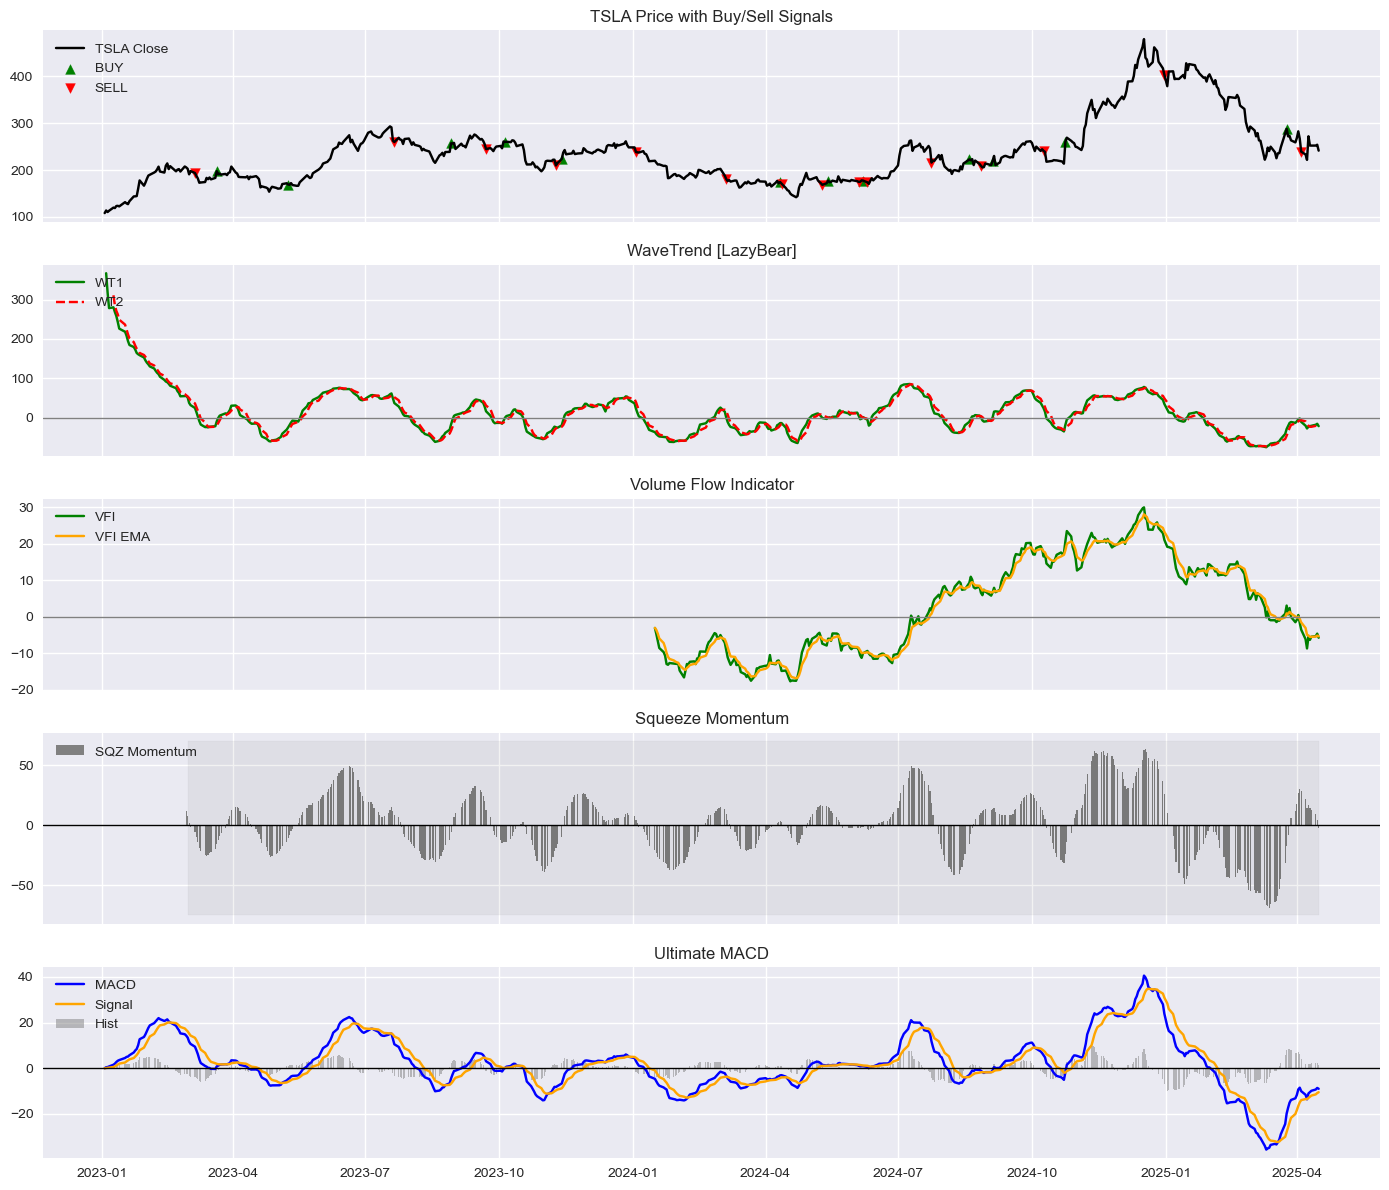

In [40]:
plt.style.use('seaborn-v0_8')

fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)
ax_price, ax_wt, ax_vfi, ax_sqz, ax_macd = axes

ax_price.plot(ohlcv_tsla.index, ohlcv_tsla['close'], label='TSLA Close', color='black')

# Mark buy/sell entries from bs_tsla
buy_idx = bs_tsla[bs_tsla['buy_signal']].index
sell_idx = bs_tsla[bs_tsla['sell_signal']].index

ax_price.scatter(buy_idx, ohlcv_tsla.loc[buy_idx, 'close'], marker='^', color='green', label='BUY')
ax_price.scatter(sell_idx, ohlcv_tsla.loc[sell_idx, 'close'], marker='v', color='red', label='SELL')

ax_price.set_title('TSLA Price with Buy/Sell Signals')
ax_price.legend(loc='upper left')

ax_wt.plot(wt_tsla.index, wt_tsla['wt1'], label='WT1', color='green')
ax_wt.plot(wt_tsla.index, wt_tsla['wt2'], label='WT2', color='red', linestyle='--')
ax_wt.axhline(0, color='gray', linewidth=1)
ax_wt.set_title('WaveTrend [LazyBear]')
ax_wt.legend(loc='upper left')

ax_vfi.plot(vfi_tsla.index, vfi_tsla['vfi'], label='VFI', color='green')
ax_vfi.plot(vfi_tsla.index, vfi_tsla['vfima'], label='VFI EMA', color='orange')
ax_vfi.axhline(0, color='gray', linewidth=1)
ax_vfi.set_title('Volume Flow Indicator')
ax_vfi.legend(loc='upper left')

ax_sqz.bar(sqz_tsla.index, sqz_tsla['val'], label='SQZ Momentum', color='gray')
ax_sqz.axhline(0, color='black', linewidth=1)

# Optional: color background when squeeze is ON
sqz_on_idx = sqz_tsla[sqz_tsla['sqz_on']].index
ax_sqz.fill_between(sqz_on_idx, ax_sqz.get_ylim()[0], ax_sqz.get_ylim()[1],
                    color='black', alpha=0.05)

ax_sqz.set_title('Squeeze Momentum')
ax_sqz.legend(loc='upper left')

ax_macd.plot(macd_tsla.index, macd_tsla['macd'], label='MACD', color='blue')
ax_macd.plot(macd_tsla.index, macd_tsla['signal'], label='Signal', color='orange')
ax_macd.bar(macd_tsla.index, macd_tsla['hist'], label='Hist', color='gray', alpha=0.5)
ax_macd.axhline(0, color='black', linewidth=1)
ax_macd.set_title('Ultimate MACD')
ax_macd.legend(loc='upper left')

plt.tight_layout()
plt.show()



- Create stacked plots showing:
  - Price with BUY/SELL markers
  - WaveTrend lines
  - VFI and its EMA
  - Squeeze Momentum histogram and shaded squeeze regions
  - MACD with histogram and signal line
- Use matplotlib subplots and scatter/bar overlays for clarity